# Steam Data Explorationg: Profitable App Profiles

In [1]:
# view software version information

# http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, pandas, matplotlib, seaborn, sklearn

Software versions
Python 3.7.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.5.0
OS Windows 10 10.0.17763 SP0
numpy 1.16.3
pandas 0.24.2
matplotlib 3.1.0
seaborn 0.9.0
sklearn 0.21.2
Tue Jun 04 12:56:46 2019 GMT Summer Time

## Ideas
- when will valve release half life 3
- best publishers/developers (or best and worst releases)
- older is better/ best year for games
- Is single-player dying? single vs multiplayer

### Issues
- prediction - low correlations so difficult

In [3]:
# standard library imports
from ast import literal_eval
import itertools
import time
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_selection import RFECV

# customisations
pd.set_option("max_columns", 100)

## Import data and preprocess for exploration

In [306]:
def remove_non_english(df):
    df = df[df['english'] == 1].copy()
    
    # doesn't contain 3 or more non-ascii characters
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    df = df.drop('english', axis=1)
    
    return df


def calc_rating(row):

    import math

    pos = row['positive']
    neg = row['negative']

    total_reviews = pos + neg

    average = pos / total_reviews

    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    cat_cols = [
#         'Captions available',
#         'Co-op',
#         'Commentary available',
#         'Cross-Platform Multiplayer',
#         'Full controller support',
#         'In-App Purchases',
#         'Includes Source SDK',
#         'Includes level editor',
#         'Local Co-op',
#         'Local Multi-Player',
#         'MMO',
#         'Mods',
#         'Mods (require HL2)',
        'Multi-player',
#         'Online Co-op',
#         'Online Multi-Player',
#         'Partial Controller Support',
#         'Shared/Split Screen',
        'Single-player'
#         'Stats',
#         'Steam Achievements',
#         'Steam Cloud',
#         'Steam Leaderboards',
#         'Steam Trading Cards',
#         'Steam Turn Notifications',
#         'Steam Workshop',
#         'SteamVR Collectibles',
#         'VR Support',
#         'Valve Anti-Cheat enabled'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    gen_cols = [
#         'Accounting',
        'Action',
        'Adventure',
#         'Animation & Modeling',
#         'Audio Production',
        'Casual',
#         'Design & Illustration',
#         'Documentary',
#         'Early Access',
#         'Education',
#         'Free to Play',
#         'Game Development',
#         'Gore',
        'Indie',
        'Massively Multiplayer',
#         'Nudity',
#         'Photo Editing',
        'RPG',
        'Racing',
#         'Sexual Content',
        'Simulation',
#         'Software Training',
        'Sports',
        'Strategy'
#         'Tutorial',
#         'Utilities',
#         'Video Production',
#         'Violent',
#         'Web Publishing'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0]
        
    tag_cols = get_unique(df['tags'])
    # df['top_tag'] = df['tags'].apply(lambda x: x.split(';')[0] if ';' in x else x)
    
    # display(cat_cols, gen_cols, tag_cols)
    df = df.drop(['categories', 'genres', 'tags'], axis=1)
    
    return df


def process_year(df):
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    return df


def process_dev_pub(df):
    for col in ['developer', 'publisher']:
        col_name = col+'_rating'
        ratings = data.groupby(col).mean()['rating']
        df[col_name] = df[col].apply(lambda x: ratings[x] if x in ratings else 0)
        
        release_counts =  data.groupby(col).count()['steam_appid']
        df[col+'_releases'] = df[col].apply(lambda x: release_counts[x] if x in release_counts else 0)
        
    return df
    
def process_revenue(df):
    df['est_revenue'] = df['owners'] * df['price']
    return df


def process_price(df):
    cut_points = [-1, 0, 4, 10, 30, 50, 1000]
    label_names = ['free', 'very cheap', 'cheap', 'moderate', 'expensive', 'very expensive']
    
    df['price_categories'] = pd.cut(df['price'], cut_points, labels=label_names)
    
    return df


def pre_process():
    steam_data = pd.read_csv('../data/steam_data_clean.csv')
    steamspy_data = pd.read_csv('../data/steamspy_clean.csv')
    
    df = steam_data.merge(steamspy_data, left_on='steam_appid', right_on='appid', suffixes=('', '_steamspy'))
    print(steam_data.shape, steamspy_data.shape, df.shape)

    df = df.drop(['appid', 'name_steamspy', 'languages'], axis=1)
    
    # english only
    df = remove_non_english(df)
    
    # windows only
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    df['owners'] = df['owners'].str.replace('[+,]', '').astype(int)
    
    # calculate ratings
    df['num_ratings'] = df['positive'] + df['negative']
    df['rating'] = df['positive'] / df['num_ratings']
    df['weighted_rating'] = df.apply(calc_rating, axis=1)
    # df = df.drop(['positive', 'negative'], axis=1)
    
    df = df.rename(columns={'average_forever': 'average_playtime', 'median_forever': 'median_playtime'})
    
    df = process_year(df)
    df = process_dev_pub(df)

    df = process_revenue(df)
    df = process_price(df)
    
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()

print(data.isnull().sum().value_counts())
data.head()

(27332, 12) (28447, 9) (27075, 21)
0    35
dtype: int64


,name,steam_appid,required_age,achievements,release_date,price,developer,publisher,positive,negative,owners,average_playtime,median_playtime,num_ratings,rating,weighted_rating,release_year,developer_rating,developer_releases,publisher_rating,publisher_releases,est_revenue,price_categories,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,Counter-Strike,10,0,0,2000-11-01,7.19,Valve,Valve,124534,3339,10000000,17612,317,127873,0.973888,95.975678,2000,0.886503,24,0.891063,28,71900000.0,cheap,1,0,1,0,0,0,0,0,0,0,0,0
1,Team Fortress Classic,20,0,0,1999-04-01,3.99,Valve,Valve,3318,633,5000000,277,62,3951,0.839787,80.508259,1999,0.886503,24,0.891063,28,19950000.0,very cheap,1,0,1,0,0,0,0,0,0,0,0,0
2,Day of Defeat,30,0,0,2003-05-01,3.99,Valve,Valve,3416,398,5000000,187,34,3814,0.895648,85.823915,2003,0.886503,24,0.891063,28,19950000.0,very cheap,1,0,1,0,0,0,0,0,0,0,0,0
3,Deathmatch Classic,40,0,0,2001-06-01,3.99,Valve,Valve,1273,267,5000000,258,184,1540,0.826623,78.126542,2001,0.886503,24,0.891063,28,19950000.0,very cheap,1,0,1,0,0,0,0,0,0,0,0,0
4,Half-Life: Opposing Force,50,0,0,1999-11-01,3.99,Gearbox Software,Valve,5250,288,5000000,624,415,5538,0.947996,91.260480,1999,0.819892,7,0.891063,28,19950000.0,very cheap,1,1,1,0,0,0,0,0,0,0,0,0


In [300]:
data.groupby('developer').count()['steam_appid']

developer
'What Day is it?' Games          1
(STCG) Smoker The Car Game       1
+7 Software                      1
+Mpact Games, LLC.               1
-Yodasaurus- Games               1
.M.Y.W.                          1
.ez Games                        1
07th Expansion                   9
08 Games                         1
0Bennyman;srslyCASUAL            1
100 Plus Games llc               1
100 Stones Interactive           1
10101 Software                   2
10Ants Hill                      2
10ft Games                       1
10ravens s.r.o.                  1
10th Art Studio;Daring Touch     1
10tons Ltd                      14
10x10 Room                       1
11 bit studios                   7
11Sheep                          1
12 East Games                    1
12 Hit Combo                     1
12 to 6 Studios LLC              1
12B3                             1
13-lab                           3
1337 & Senri AB                  1
13AM Games                       2
14 Dimensi

In [288]:
data['price_categories'].value_counts()

very cheap        11224
cheap              7744
moderate           4362
free               2353
expensive           251
very expensive       17
Name: price_categories, dtype: int64

In [310]:
data.corr().abs()['strategy'].sort_values(ascending=False)

strategy                 1.000000
action                   0.154103
adventure                0.145856
simulation               0.142821
multi_player             0.124397
rpg                      0.078209
racing                   0.066561
price                    0.064660
steam_appid              0.064642
release_year             0.048567
developer_rating         0.045614
publisher_rating         0.045428
rating                   0.044215
massively_multiplayer    0.039729
achievements             0.039546
required_age             0.031979
indie                    0.026127
weighted_rating          0.022415
sports                   0.020286
casual                   0.017097
median_playtime          0.013583
developer_releases       0.013375
average_playtime         0.012219
single_player            0.011236
owners                   0.005162
publisher_releases       0.004082
num_ratings              0.003617
negative                 0.003511
positive                 0.003481
est_revenue   

In [ ]:
# junk     
# df = df[df['average_playtime'] > 0]
# df = df[df['rating'] > 0]

# free
# df = df[df['price'] > 0]

In [252]:
data.groupby('developer').mean().loc[['Valve', 'Gearbox Software'], :]

data.groupby('developer').mean()['rating'].sort_values(ascending=False)

dev_pv = data.pivot_table(index='developer', values=['steam_appid', 'num_ratings', 'rating'], aggfunc={'rating':np.mean, 'steam_appid': len, 'num_ratings': np.sum}).sort_values(by='rating', ascending=False)

dev_pv[dev_pv['steam_appid'] >= 10].rename({'rating':'average_rating','steam_appid':'num_apps'}, axis=1)

,num_ratings,average_rating,num_apps
developer,,,
Valve,2474157,86.583035,26
Nihon Falcom,14283,86.084292,15
"PopCap Games, Inc.",21379,82.129938,10
Artifex Mundi,10240,81.315946,16
id Software,146700,81.099485,18
Quiet River,26456,80.880473,21
Bethesda Game Studios,561774,80.565951,10
SEGA,33334,80.303559,11
Frontwing,3071,80.175855,21


In [238]:
data.groupby('publisher').mean()['rating'].sort_values(ascending=False)

pub_pv = data.pivot_table(index='publisher', values=['steam_appid', 'rating'], aggfunc={'rating':np.mean, 'steam_appid': len}, fill_value=0).sort_values(by='rating', ascending=False)

pub_pv[pub_pv['steam_appid'] >= 10]

,rating,steam_appid
publisher,,
Valve,87.802773,21
MangaGamer,86.232008,11
Quiet River,85.380483,12
Sekai Project,84.273627,35
Microsoft Studios,83.581961,18
AGM PLAYISM,82.043259,18
id Software,81.813134,13
Adult Swim Games,80.274773,12
Bethesda Softworks,79.860181,30


In [169]:
counts = data['top_tag'].value_counts()
counts[counts > 100]

Action          906
Indie           831
Adventure       464
Strategy        439
Casual          374
RPG             290
Early Access    260
Simulation      198
Racing          108
Name: top_tag, dtype: int64

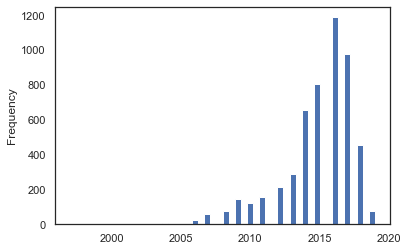

In [142]:
data['release_year'].plot.hist(bins=50)

In [129]:
pd.pivot_table(data, index=['publisher'], values=['average_playtime', 'rating', 'owners', 'publisher_rating', 'est_revenue']).sort_values(by='est_revenue', ascending=False)

,average_playtime,est_revenue,owners,publisher_rating,rating
publisher,,,,,
PUBG Corporation,22938.000000,1.349500e+09,5.000000e+07,50.066901,50.066901
Warner Bros Interactive Entertainment,636.000000,2.249500e+08,5.000000e+06,83.520727,83.520727
Studio Wildcard,14154.000000,2.249500e+08,5.000000e+06,67.675307,67.675307
Facepunch Studios,9352.000000,1.389500e+08,5.000000e+06,79.476392,79.476392
Activision (Excluding Japan and Asia);FromSoftware (Japan);方块游戏 (Asia),2059.000000,9.980000e+07,2.000000e+06,85.597323,85.597323
Torn Banner Studios,675.000000,9.495000e+07,5.000000e+06,80.995161,80.995161
"FromSoftware, Inc.;BANDAI NAMCO Entertainment",4222.000000,7.998000e+07,2.000000e+06,89.601741,89.601741
2K;Aspyr (Mac);Aspyr (Linux),2800.000000,7.797000e+07,3.000000e+06,76.067083,76.067083
"Psyonix, Inc.",5825.000000,7.495000e+07,5.000000e+06,90.678317,90.678317


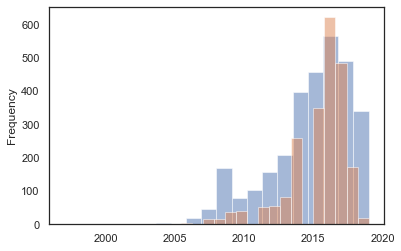

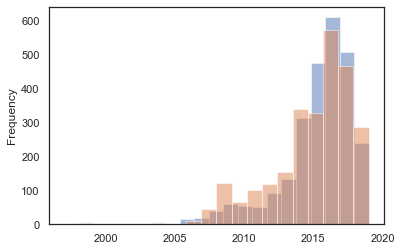

In [130]:
data.loc[data['rating'] > data['rating'].mean(), 'release_year'].plot.hist(alpha=.5, bins=20)
data.loc[data['rating'] < data['rating'].mean(), 'release_year'].plot.hist(alpha=.5, bins=20)
plt.show()

data.loc[data['average_playtime'] > data['average_playtime'].median(), 'release_year'].plot.hist(alpha=0.5, bins=20)
data.loc[data['average_playtime'] < data['average_playtime'].median(), 'release_year'].plot.hist(alpha=0.5, bins=20)
plt.show()

In [131]:
dev_ratings = data.groupby('developer').mean()['rating'].sort_values(ascending=False)

dev_ratings[dev_ratings > 90]

developer
Wube Software LTD.                                                                   96.601391
Re-Logic                                                                             95.907030
Ludeon Studios                                                                       95.802600
ConcernedApe                                                                         95.490248
Silver Dollar Games                                                                  95.478482
Kristjan Skutta                                                                      95.309165
Gears for Breakfast                                                                  95.211549
Little Cat Feet                                                                      95.076179
Sukeban Games                                                                        94.830148
KAGAMI WORKs                                                                         94.453453
Steel Crate Games                       

In [143]:
data.corr()['est_revenue'].abs().sort_values()

g_adventure                     0.000244
g_game_development              0.000260
g_animation_and_modeling        0.000512
g_strategy                      0.001198
g_video_production              0.001315
g_sports                        0.001626
g_education                     0.002107
g_software_training             0.002107
g_audio_production              0.002937
c_local_co_op                   0.002980
g_free_to_play                  0.002981
c_local_multi_player            0.003077
g_design_and_illustration       0.003825
g_photo_editing                 0.004237
c_steamvr_collectibles          0.004379
g_utilities                     0.004589
achievements                    0.004857
c_steam_turn_notifications      0.005687
g_web_publishing                0.005791
g_racing                        0.005793
g_simulation                    0.005866
g_nudity                        0.006421
c_partial_controller_support    0.007513
c_steam_leaderboards            0.008014
g_sexual_content

200000      990
20000       957
100000      947
50000       848
0           720
500000      395
1000000     227
2000000     127
5000000      32
10000000     12
50000000      1
Name: owners, dtype: int64


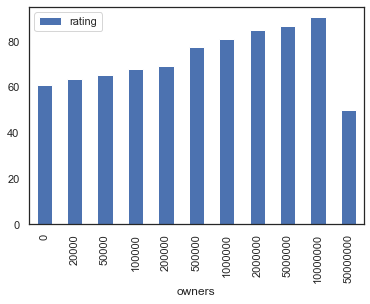

In [132]:
# data.corr()['owners'].sort_values()
print(data['owners'].value_counts())

data.pivot_table(index="owners", values="rating").plot.bar()
plt.show()

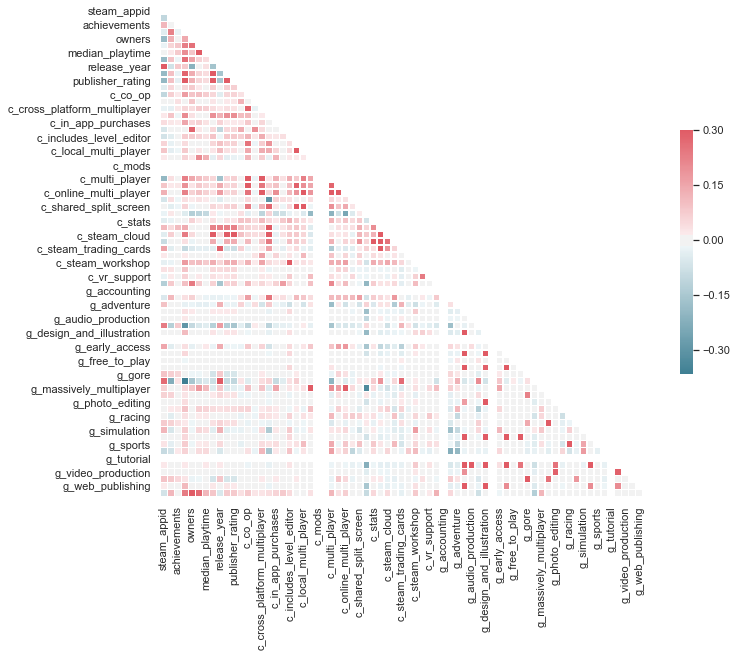

In [133]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

# correlations = data.corr()
# sns.heatmap(correlations)
plot_correlation_heatmap(data)

In [135]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

numeric = data.select_dtypes(include='number').dropna(axis=1).copy()
display(numeric.head())
all_X = numeric.drop(['rating', 'owners', 'est_revenue', 'steam_appid'], axis=1)
all_y = numeric['est_revenue']

lr = LinearRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)
optimised_columns = all_X.columns[selector.support_]
optimised_columns

,steam_appid,required_age,achievements,price,owners,average_playtime,median_playtime,rating,release_year,developer_rating,publisher_rating,c_captions_available,c_co_op,c_commentary_available,c_cross_platform_multiplayer,c_full_controller_support,c_in_app_purchases,c_includes_source_sdk,c_includes_level_editor,c_local_co_op,c_local_multi_player,c_mmo,c_mods,c_mods_require_hl2,c_multi_player,c_online_co_op,c_online_multi_player,c_partial_controller_support,c_shared_split_screen,c_single_player,c_stats,c_steam_achievements,c_steam_cloud,c_steam_leaderboards,c_steam_trading_cards,c_steam_turn_notifications,c_steam_workshop,c_steamvr_collectibles,c_vr_support,c_valve_anti_cheat_enabled,g_accounting,g_action,g_adventure,g_animation_and_modeling,g_audio_production,g_casual,g_design_and_illustration,g_documentary,g_early_access,g_education,g_free_to_play,g_game_development,g_gore,g_indie,g_massively_multiplayer,g_nudity,g_photo_editing,g_rpg,g_racing,g_sexual_content,g_simulation,g_software_training,g_sports,g_strategy,g_tutorial,g_utilities,g_video_production,g_violent,g_web_publishing,est_revenue
0,10,0,0,7.19,10000000,17612,317,95.975678,2000,87.303677,87.802773,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71900000.0
1,20,0,0,3.99,5000000,277,62,80.508259,1999,87.303677,87.802773,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19950000.0
2,30,0,0,3.99,5000000,187,34,85.823915,2003,87.303677,87.802773,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19950000.0
3,40,0,0,3.99,5000000,258,184,78.126542,2001,87.303677,87.802773,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19950000.0
4,50,0,0,3.99,5000000,624,415,91.260480,1999,80.587073,87.802773,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19950000.0


Index(['c_includes_source_sdk'], dtype='object')

In [136]:
from sklearn.model_selection import cross_val_score

all_X = numeric[optimised_columns]
all_y = numeric['est_revenue']

lr = LinearRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

-0.15741257877406506

In [67]:
for col in ['categories', 'genres', 'tags']:
    print('\n----------{}----------\n'.format(col))
    print(data[col].value_counts().head(10))


----------categories----------

Single-player                                                                               5807
Single-player;Steam Achievements                                                            2253
Single-player;Steam Achievements;Steam Trading Cards                                         840
Single-player;Steam Trading Cards                                                            779
Single-player;Partial Controller Support                                                     775
Single-player;Steam Achievements;Steam Trading Cards;Steam Cloud                             628
Single-player;Steam Achievements;Steam Cloud                                                 585
Single-player;Steam Achievements;Full controller support;Steam Trading Cards;Steam Cloud     556
Single-player;Full controller support                                                        544
Single-player;Steam Achievements;Full controller support                                     4

In [77]:
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))
    
get_unique(data['categories'])

{'Captions available',
 'Co-op',
 'Commentary available',
 'Cross-Platform Multiplayer',
 'Full controller support',
 'In-App Purchases',
 'Includes Source SDK',
 'Includes level editor',
 'Local Co-op',
 'Local Multi-Player',
 'MMO',
 'Mods',
 'Mods (require HL2)',
 'Multi-player',
 'Online Co-op',
 'Online Multi-Player',
 'Partial Controller Support',
 'Shared/Split Screen',
 'Single-player',
 'Stats',
 'Steam Achievements',
 'Steam Cloud',
 'Steam Leaderboards',
 'Steam Trading Cards',
 'Steam Turn Notifications',
 'Steam Workshop',
 'SteamVR Collectibles',
 'VR Support',
 'Valve Anti-Cheat enabled'}

In [10]:
# most common
genre_data = final_data[['steam_appid', 'genres']].copy()

genre_cols = set(list(itertools.chain(*genre_data['genres'].apply(lambda x: [item for item in x.split(';')]))))

for col in sorted(genre_cols):
    col_name = col.lower().replace('&', 'and').replace(' ', '_')

    genre_data[col_name] = genre_data['genres'].apply(lambda x: 1 if col in x else 0)
    
genre_data.drop(['steam_appid', 'genres'], axis=1).sum().sort_values(ascending=False)

indie                      18849
action                     11664
casual                      9899
adventure                   9637
strategy                    5009
simulation                  4995
rpg                         3944
early_access                2839
free_to_play                1620
sports                      1302
racing                      1008
violent                      820
massively_multiplayer        682
gore                         525
nudity                       250
sexual_content               231
utilities                    137
design_and_illustration       78
animation_and_modeling        68
education                     44
video_production              36
audio_production              27
software_training             26
web_publishing                23
game_development              11
photo_editing                 11
accounting                     5
documentary                    1
tutorial                       1
dtype: int64

In [11]:
# most popular
genre_owners_data = pd.concat([genre_data.drop(['steam_appid', 'genres'], axis=1), final_data['owners'].str.replace('[+,]', '').astype(int)], axis=1).copy()

genre_owners_data.head()

,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,owners
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10000000
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000


In [12]:
for col in genre_owners_data.columns.drop('owners'):
    genre_owners_data[col] *= genre_owners_data['owners']

genre_owners_data.head()    

,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,owners
0,0,10000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10000000
1,0,5000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000
2,0,5000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000
3,0,5000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000
4,0,5000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000000


In [13]:
genre_owners_data.sum().sort_values(ascending=False)

owners                     2156000000
action                     1439270000
indie                       811440000
adventure                   641250000
free_to_play                631890000
strategy                    460300000
rpg                         413950000
simulation                  302930000
casual                      283810000
massively_multiplayer       283360000
early_access                 78220000
sports                       58590000
racing                       49500000
violent                      20790000
gore                         13190000
nudity                       12760000
utilities                     9040000
sexual_content                8920000
animation_and_modeling        7450000
design_and_illustration       6790000
video_production              1800000
web_publishing                1250000
education                      660000
software_training              510000
game_development               300000
photo_editing                  210000
audio_produc

In [14]:
# category_data = final_data['categories']..copy()
category_data = pd.DataFrame()

# genre_cols = set(list(itertools.chain(*genre_data['genres'].apply(lambda x: [item for item in x.split(';')]))))
cat_cols = set(list(itertools.chain(*final_data['categories'].apply(lambda x: [c for c in x.split(';')]))))

for col in cat_cols:
    col_name = re.sub(r'[\s\-\/]', '_', col.lower())
    col_name = re.sub(r'[()]', '', col_name)
    
    category_data[col_name] = final_data['categories'].apply(lambda x: 1 if col in x else 0)  

category_data.head()

,vr_support,co_op,mmo,single_player,stats,steam_leaderboards,mods_require_hl2,includes_level_editor,steam_workshop,local_co_op,multi_player,captions_available,full_controller_support,cross_platform_multiplayer,local_multi_player,steam_turn_notifications,steam_achievements,valve_anti_cheat_enabled,steam_cloud,shared_split_screen,steamvr_collectibles,partial_controller_support,online_multi_player,commentary_available,mods,in_app_purchases,steam_trading_cards,includes_source_sdk,online_co_op
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:
category_data.sum().sort_values(ascending=False)

single_player                 24834
steam_achievements            13764
steam_trading_cards            7772
steam_cloud                    6918
full_controller_support        5597
partial_controller_support     4106
multi_player                   3913
steam_leaderboards             3387
co_op                          2561
online_multi_player            2414
shared_split_screen            2129
stats                          1860
local_multi_player             1593
cross_platform_multiplayer     1071
online_co_op                   1048
local_co_op                    1041
includes_level_editor          1029
steam_workshop                  883
captions_available              714
in_app_purchases                659
mmo                             401
vr_support                      230
commentary_available            135
valve_anti_cheat_enabled         94
steam_turn_notifications         63
steamvr_collectibles             40
includes_source_sdk              35
mods                        

In [25]:
# cat_owners_data = pd.concat([category_data, final_data['owners_int']], axis=1)
final_data['owners_int'] = final_data['owners'].str.replace('[+,]', '').astype(int)
cat_owners_data = category_data.apply(lambda x: x * final_data['owners_int'])
cat_owners_data.sum().sort_values(ascending=False)

single_player                 1585130000
steam_achievements            1294260000
steam_trading_cards           1281540000
multi_player                  1111770000
steam_cloud                    812090000
co_op                          675200000
full_controller_support        596610000
in_app_purchases               465620000
steam_workshop                 457780000
online_multi_player            444360000
partial_controller_support     437440000
valve_anti_cheat_enabled       375490000
stats                          359220000
includes_level_editor          267180000
steam_leaderboards             261160000
online_co_op                   232600000
cross_platform_multiplayer     229570000
mmo                            194600000
captions_available             170700000
shared_split_screen            134320000
steamvr_collectibles           102900000
local_multi_player              93310000
commentary_available            90380000
includes_source_sdk             86320000
local_co_op     

In [30]:
total = cat_owners_data.sum().sum()
cat_owners_data.sum().sort_values(ascending=False) / total * 100

single_player                 13.351150
steam_achievements            10.901226
steam_trading_cards           10.794088
multi_player                   9.364158
steam_cloud                    6.840029
co_op                          5.687039
full_controller_support        5.025096
in_app_purchases               3.921800
steam_workshop                 3.855765
online_multi_player            3.742732
partial_controller_support     3.684447
valve_anti_cheat_enabled       3.162658
stats                          3.025619
includes_level_editor          2.250390
steam_leaderboards             2.199685
online_co_op                   1.959131
cross_platform_multiplayer     1.933610
mmo                            1.639067
captions_available             1.437763
shared_split_screen            1.131343
steamvr_collectibles           0.866701
local_multi_player             0.785927
commentary_available           0.761248
includes_source_sdk            0.727052
local_co_op                    0.487003


In [19]:
# high playtime
final_data.sort_values('average_forever', ascending=False).head(100).reset_index(drop=True)

,name_x,steam_appid,required_age,platforms,categories,genres,achievements,release_date,price,english,developer,publisher,appid,name_y,positive,negative,owners,average_forever,median_forever,languages,tags,name,owners_int
0,The Abbey of Crime Extensum,474030,0,windows;mac;linux,Single-player,Adventure;Free to Play,0,2016-05-19,0.00,1,Manuel Pazos;Daniel Celemín,Manuel Pazos;Daniel Celemín,474030,The Abbey of Crime Extensum,146,22,"50,000+",190625,190625,"English, Spanish - Spain, Italian, French",Free to Play;Adventure;Retro;Remake;Isometric,The Abbey of Crime Extensum,50000
1,The Banner Saga: Factions,219340,0,windows;mac,Multi-player;Cross-Platform Multiplayer,Free to Play;Indie;RPG;Strategy,42,2013-02-25,0.00,1,Stoic,Versus Evil,219340,The Banner Saga: Factions,569,202,"200,000+",95245,190489,English,Free to Play;Strategy;RPG;Indie;Turn-Based Str...,The Banner Saga: Factions,200000
2,The Secret of Tremendous Corporation,380140,0,windows;linux,Single-player;Captions available;Steam Cloud,Adventure;Casual;Free to Play;Indie,0,2015-10-12,0.00,1,Sebastian Krzyszkowiak;Konrad Burandt;Paweł Radej,dosowisko.net,380140,The Secret of Tremendous Corporation,218,50,"100,000+",95242,190445,English,Free to Play;Adventure;Indie;Casual;Point & Click,The Secret of Tremendous Corporation,100000
3,PRICE,465520,0,windows,Single-player;Steam Achievements;Steam Trading...,Adventure;Casual;Indie,8,2016-09-15,0.00,1,YETU GAME,YETU GAME,465520,PRICE,4198,233,"200,000+",63481,63490,"English, Simplified Chinese, Japanese",Puzzle;Free to Play;Anime;Indie;Horror,PRICE,200000
4,Boundless,324510,0,windows;mac,Multi-player;Online Multi-Player;MMO;Co-op;Onl...,Action;Adventure;Indie;Massively Multiplayer;RPG,59,2018-09-11,32.99,1,Wonderstruck,Square Enix,324510,Boundless,1153,486,"20,000+",55204,55204,"English, French, Italian, German, Spanish - Spain",Sandbox;Massively Multiplayer;Open World;Craft...,Boundless,20000
5,Shroud of the Avatar: Forsaken Virtues,326160,0,windows;mac;linux,Single-player;Multi-player;MMO;Co-op;Cross-Pla...,Free to Play;Massively Multiplayer;RPG,29,2018-03-27,0.00,1,Portalarium,Portalarium,326160,Shroud of the Avatar: Forsaken Virtues,1065,1017,"50,000+",54618,54618,"English, Russian",RPG;Massively Multiplayer;Free to Play;MMORPG;...,Shroud of the Avatar: Forsaken Virtues,50000
6,X-Plane 11,269950,0,windows;mac;linux,Single-player;Local Multi-Player;Partial Contr...,Simulation,0,2017-03-30,54.99,1,Laminar Research,Laminar Research,269950,X-Plane 11,2033,443,"100,000+",44169,44169,"English, French, Italian, German, Spanish - Sp...",Simulation;Flight;Realistic;Open World;Multipl...,X-Plane 11,100000
7,Fantasy Grounds,252690,0,windows;mac,Multi-player;Co-op;Cross-Platform Multiplayer,Indie;RPG;Strategy,0,2014-05-09,29.99,1,"SmiteWorks USA, LLC","SmiteWorks USA, LLC",252690,Fantasy Grounds,377,100,"20,000+",43074,86148,English,RPG;Strategy;Software;Indie;Turn-Based,Fantasy Grounds,20000
8,Screeps,464350,0,windows;mac;linux,Single-player;Online Multi-Player;MMO;Steam Tr...,Indie;Massively Multiplayer;Strategy,0,2016-11-16,10.99,1,Screeps,Screeps,464350,Screeps,736,97,"20,000+",38805,38805,English,Programming;Strategy;Massively Multiplayer;Ind...,Screeps,20000
9,The Price of Freedom,561080,0,windows,Single-player,Adventure;Indie,0,2016-12-22,0.00,1,Construct Studio,Construct Studio Inc.,561080,The Price of Freedom,333,22,"50,000+",36029,36029,"English, Traditional Chinese",Indie;Adventure;Story Rich;VR;Cinematic,The Price of Freedom,50000


In [20]:
# popular publishers
final_data.groupby('publisher').mean().sort_values('owners_int', ascending=False).head(25)

,steam_appid,required_age,achievements,price,english,appid,positive,negative,average_forever,median_forever,owners_int
publisher,,,,,,,,,,,
PUBG Corporation,578080.000000,0.0,37.0,26.990000,1.0,578080.000000,496184.000000,487076.000000,22938.000000,12434.000000,5.000000e+07
Smartly Dressed Games,304930.000000,0.0,46.0,0.000000,1.0,304930.000000,292574.000000,31482.000000,3248.000000,413.000000,2.000000e+07
Digital Extremes,230410.000000,16.0,187.0,0.000000,1.0,230410.000000,226541.000000,20268.000000,5845.000000,394.000000,2.000000e+07
Valve,34932.333333,0.0,42.0,4.479667,1.0,34932.333333,175689.066667,21337.866667,3505.100000,544.500000,1.121667e+07
RETO MOTO,227940.000000,0.0,0.0,0.000000,1.0,227940.000000,65856.000000,34416.000000,1752.000000,76.000000,1.000000e+07
Grinding Gear Games,238960.000000,0.0,120.0,0.000000,1.0,238960.000000,71593.000000,6117.000000,5263.000000,492.000000,1.000000e+07
Freejam,611105.000000,0.0,21.5,5.695000,1.0,611105.000000,40457.500000,15652.500000,684.500000,105.500000,5.010000e+06
Nexon Korea Corporation,273110.000000,0.0,65.0,0.000000,1.0,273110.000000,22130.000000,12127.000000,4047.000000,112.000000,5.000000e+06
Expansive Worlds;Avalanche Studios,253710.000000,0.0,159.0,0.000000,1.0,253710.000000,11440.000000,15403.000000,163.000000,29.000000,5.000000e+06


In [21]:
# popular developers
final_data.groupby('developer').mean().sort_values('owners_int', ascending=False).head(25)

,steam_appid,required_age,achievements,price,english,appid,positive,negative,average_forever,median_forever,owners_int
developer,,,,,,,,,,,
Valve;Hidden Path Entertainment,730.000000,0.000000,167.000000,0.000000,1.0,730.000000,2.644404e+06,402313.000000,22494.000000,6502.000000,5.000000e+07
PUBG Corporation,578080.000000,0.000000,37.000000,26.990000,1.0,578080.000000,4.961840e+05,487076.000000,22938.000000,12434.000000,5.000000e+07
Smartly Dressed Games,304930.000000,0.000000,46.000000,0.000000,1.0,304930.000000,2.925740e+05,31482.000000,3248.000000,413.000000,2.000000e+07
Valve,40117.692308,0.000000,40.923077,4.593077,1.0,40117.692308,8.667212e+04,8487.769231,2663.538462,282.230769,1.025000e+07
Blue Mammoth Games,291550.000000,0.000000,39.000000,0.000000,1.0,291550.000000,7.326800e+04,14489.000000,724.000000,146.000000,1.000000e+07
OVERKILL - a Starbreeze Studio.,218620.000000,18.000000,1130.000000,7.490000,1.0,218620.000000,3.086570e+05,56523.000000,3975.000000,890.000000,1.000000e+07
Evil Mojo Games,444090.000000,0.000000,58.000000,0.000000,1.0,444090.000000,1.695800e+05,32407.000000,1595.000000,407.000000,1.000000e+07
RETO MOTO,227940.000000,0.000000,0.000000,0.000000,1.0,227940.000000,6.585600e+04,34416.000000,1752.000000,76.000000,1.000000e+07
NantG,433850.000000,0.000000,0.000000,0.000000,1.0,433850.000000,1.114340e+05,91664.000000,3142.000000,162.000000,1.000000e+07


In [22]:
# ratings
import math

def calc_rating(row):
    pos = row['positive']
    neg = row['negative']
    
    total_reviews = pos + neg
    
    average = pos / total_reviews
    
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))
    
    return score * 100

final_data['rating'] = final_data.apply(calc_rating, axis=1)

final_data.sort_values('rating', ascending=False).head(25)

,name_x,steam_appid,required_age,platforms,categories,genres,achievements,release_date,price,english,developer,publisher,appid,name_y,positive,negative,owners,average_forever,median_forever,languages,tags,name,owners_int,rating
23,Portal 2,620,0,windows;mac;linux,Single-player;Co-op;Steam Achievements;Full co...,Action;Adventure,51,2011-04-18,7.19,1,Valve,Valve,620,Portal 2,138220,1891,"10,000,000+",1102,520,"English, French, German, Spanish - Spain, Czec...",Puzzle;Co-op;First-Person;Sci-fi;Comedy,Portal 2,10000000,97.257760
7577,Factorio,427520,0,windows;mac;linux,Single-player;Multi-player;Online Multi-Player...,Casual;Indie;Simulation;Strategy;Early Access,38,2016-02-25,21.00,1,Wube Software LTD.,Wube Software LTD.,427520,Factorio,47918,723,"1,000,000+",10087,6880,"English, French, Italian, German, Spanish - Sp...",Early Access;Base-Building;Resource Management...,Factorio,1000000,96.601391
2964,The Witcher® 3: Wild Hunt,292030,0,windows,Single-player;Steam Achievements;Full controll...,RPG,78,2015-05-18,24.99,1,CD PROJEKT RED,CD PROJEKT RED,292030,The Witcher 3: Wild Hunt,202930,4798,"5,000,000+",3068,2002,"English, French, Italian, German, Spanish - Sp...",Open World;RPG;Story Rich;Atmospheric;Mature,The Witcher 3: Wild Hunt,5000000,96.465364
17,Portal,400,0,windows;mac;linux,Single-player;Steam Achievements;Captions avai...,Action,15,2007-10-10,7.19,1,Valve,Valve,400,Portal,51801,1080,"10,000,000+",288,137,"English, French, German, Russian, Danish, Dutc...",Puzzle;First-Person;Singleplayer;Sci-fi;Comedy,Portal,10000000,96.103502
0,Counter-Strike,10,0,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,2000-11-01,7.19,1,Valve,Valve,10,Counter-Strike,124534,3339,"10,000,000+",17612,317,"English, French, German, Italian, Spanish - Sp...",Action;FPS;Multiplayer;Shooter;Classic,Counter-Strike,10000000,95.975678
1120,Terraria,105600,0,windows;mac;linux,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Indie;RPG,88,2011-05-16,6.99,1,Re-Logic,Re-Logic,105600,Terraria,255600,7797,"5,000,000+",5585,1840,"English, French, Italian, German, Spanish - Sp...",Sandbox;Adventure;Survival;Multiplayer;Crafting,Terraria,5000000,95.907030
1962,The Binding of Isaac: Rebirth,250900,16,windows;mac;linux,Single-player;Shared/Split Screen;Steam Achiev...,Action,403,2014-11-04,10.99,1,"Nicalis, Inc.","Nicalis, Inc.",250900,The Binding of Isaac: Rebirth,72830,1840,"2,000,000+",4583,3236,English,Indie;Replay Value;Rogue-like;Difficult;Pixel ...,The Binding of Isaac: Rebirth,2000000,95.871763
3036,RimWorld,294100,0,windows;mac;linux,Single-player;Steam Workshop;Steam Cloud,Indie;Simulation;Strategy,0,2018-10-17,27.79,1,Ludeon Studios,Ludeon Studios,294100,RimWorld,38556,857,"1,000,000+",5017,2106,"English, French, German, Polish, Russian, Ital...",Base-Building;Survival;Strategy;Sandbox;Building,RimWorld,1000000,95.802600
21,Left 4 Dead 2,550,0,windows;mac;linux,Single-player;Multi-player;Co-op;Steam Achieve...,Action,70,2009-11-19,7.19,1,Valve,Valve,550,Left 4 Dead 2,251789,8418,"10,000,000+",1615,566,"Danish, Dutch, English, Finnish, French, Germa...",Zombies;Co-op;FPS;Multiplayer;Action,Left 4 Dead 2,10000000,95.631142
1596,Euro Truck Simulator 2,227300,0,windows;mac;linux,Single-player;Steam Achievements;Steam Trading...,Indie;Simulation,67,2012-10-12,14.99,1,SCS Software,SCS Software,227300,Euro Truck Simulator 2,176769,5825,"5,000,000+",4942,1413,"English, German, French, Italian, Korean, Span...",Simulation;Driving;Open World;Realistic;Relaxing,Euro Truck Simulator 2,5000000,95.547966


In [23]:
# simple ratings
final_data['simple_rating'] = final_data['positive'] / (final_data['positive'] + final_data['negative'])
final_data[final_data['owners_int'] > 20000].sort_values('simple_rating', ascending=False).head(25)

,name_x,steam_appid,required_age,platforms,categories,genres,achievements,release_date,price,english,developer,publisher,appid,name_y,positive,negative,owners,average_forever,median_forever,languages,tags,name,owners_int,rating,simple_rating
9110,Linelight,469790,0,windows;mac;linux,Single-player;Steam Achievements;Full controll...,Action;Adventure;Casual;Indie,25,2017-01-30,6.99,1,My Dog Zorro,My Dog Zorro,469790,Linelight,447,6,"50,000+",0,0,"English, French, Italian, German, Spanish - Sp...",Indie;Casual;Puzzle;Action;Adventure,Linelight,50000,90.853353,0.986755
23,Portal 2,620,0,windows;mac;linux,Single-player;Co-op;Steam Achievements;Full co...,Action;Adventure,51,2011-04-18,7.19,1,Valve,Valve,620,Portal 2,138220,1891,"10,000,000+",1102,520,"English, French, German, Spanish - Spain, Czec...",Puzzle;Co-op;First-Person;Sci-fi;Comedy,Portal 2,10000000,97.257760,0.986504
6190,Paint it Back,385250,0,windows;mac;linux,Single-player;Steam Achievements;Full controll...,Casual,20,2015-10-14,5.59,1,Casual Labs,Casual Labs,385250,Paint it Back,361,5,"50,000+",0,0,English,Casual;Puzzle;Indie,Paint it Back,50000,90.297937,0.986339
7577,Factorio,427520,0,windows;mac;linux,Single-player;Multi-player;Online Multi-Player...,Casual;Indie;Simulation;Strategy;Early Access,38,2016-02-25,21.00,1,Wube Software LTD.,Wube Software LTD.,427520,Factorio,47918,723,"1,000,000+",10087,6880,"English, French, Italian, German, Spanish - Sp...",Early Access;Base-Building;Resource Management...,Factorio,1000000,96.601391,0.985136
7130,TY the Tasmanian Tiger,411960,0,windows,Single-player;Steam Achievements;Full controll...,Action;Adventure;Indie,39,2016-12-12,10.99,1,Krome Studios,Krome Studios,411960,TY the Tasmanian Tiger,1676,26,"50,000+",117,117,"English, French, Italian, German, Spanish - Spain",Adventure;3D Platformer;Action;Classic;Singlep...,TY the Tasmanian Tiger,50000,93.229240,0.984724
7755,Epic Battle Fantasy 5,432350,0,windows,Single-player;Steam Achievements;Steam Trading...,Adventure;RPG;Strategy,102,2018-11-30,11.49,1,Matt Roszak,Matt Roszak,432350,Epic Battle Fantasy 5,1073,19,"50,000+",0,0,"English, French, German, Portuguese - Brazil, ...",RPG;Adventure;Strategy;Turn-Based;Funny,Epic Battle Fantasy 5,50000,92.281036,0.982601
2290,One Finger Death Punch,264200,0,windows,Single-player;Steam Achievements;Partial Contr...,Action;Casual;Indie,152,2014-03-03,3.99,1,Silver Dollar Games,Silver Dollar Games,264200,One Finger Death Punch,14181,256,"500,000+",149,107,English,Action;Fast-Paced;Indie;Beat 'em up;Fighting,One Finger Death Punch,500000,95.478482,0.982268
7563,Narcissu 10th Anniversary Anthology Project,426690,0,windows,Single-player;Steam Trading Cards,Casual;Indie,0,2016-01-27,1.99,1,stage-nana,Sekai Project,426690,Narcissu 10th Anniversary Anthology Project,327,6,"50,000+",157,157,"English, Japanese",Indie;Casual;Visual Novel;Anime;Story Rich,Narcissu 10th Anniversary Anthology Project,50000,89.660316,0.981982
4344,Finding Paradise,337340,0,windows;mac;linux,Single-player;Steam Achievements;Steam Trading...,Adventure;Indie;RPG,1,2017-12-14,6.99,1,Freebird Games,Freebird Games,337340,Finding Paradise,6578,123,"200,000+",166,166,"English, Simplified Chinese, Polish, Ukrainian...",Story Rich;Great Soundtrack;Pixel Graphics;Ind...,Finding Paradise,200000,94.704088,0.981645
23649,NEKOPARA Extra,899970,0,windows,Single-player;Steam Achievements;Steam Trading...,Casual;Indie,13,2018-07-26,3.99,1,NEKO WORKs,Sekai Project,899970,NEKOPARA Extra,1527,29,"50,000+",206,412,"English, Japanese, Traditional Chinese",Anime;Visual Novel;Sexual Content;Nudity;Cute,NEKOPARA Extra,50000,92.768095,0.981362


In [33]:
final_data.groupby('owners_int').mean().sort_index()

,steam_appid,required_age,achievements,price,english,appid,positive,negative,average_forever,median_forever,rating,simple_rating
owners_int,,,,,,,,,,,,
0,679148.356227,0.176210,48.005038,5.424987,1.0,679148.356227,2.981662e+01,9.972852,12.305066,12.401399,54.979678,0.705260
20000,465568.924242,0.269697,48.240067,6.076916,1.0,465568.924242,1.754411e+02,54.083838,161.093266,179.471044,62.673069,0.710160
50000,424596.947590,0.343976,48.275301,6.268373,1.0,424596.947590,3.785518e+02,114.089759,370.108434,393.207229,65.018401,0.716584
100000,380901.389706,0.531618,28.204412,7.147787,1.0,380901.389706,8.277243e+02,224.284559,424.370588,546.160294,67.212260,0.725700
200000,338072.864865,0.834658,37.116852,7.148617,1.0,338072.864865,1.743568e+03,450.647059,542.837838,683.456280,68.958985,0.733444
500000,282228.730469,2.306641,34.015625,10.114609,1.0,282228.730469,5.136105e+03,1181.109375,853.388672,763.490234,75.978503,0.794020
1000000,239295.384615,3.482517,44.475524,12.218706,1.0,239295.384615,1.179687e+04,2440.727273,1313.513986,831.513986,79.367423,0.820583
2000000,226694.635417,3.760417,59.614583,10.624167,1.0,226694.635417,2.609835e+04,4246.338542,1381.359375,518.984375,81.598384,0.837480
5000000,218477.391304,1.913043,62.956522,10.749565,1.0,218477.391304,6.910933e+04,11581.695652,2677.543478,722.717391,82.338574,0.842493


In [38]:
final_data['price_bins'] = pd.cut(final_data['price'], bins=10)
final_data.groupby('price_bins').mean().sort_index()

,steam_appid,required_age,achievements,price,english,appid,positive,negative,average_forever,median_forever,owners_int,rating,simple_rating
price_bins,,,,,,,,,,,,,
"(-0.07, 6.999]",605231.573005,0.198623,45.071534,3.033482,1.0,605231.573005,632.168979,124.160254,112.536266,109.977294,63321.244613,56.560401,0.697717
"(6.999, 13.998]",573470.244547,0.489535,54.585592,9.633534,1.0,573470.244547,1052.385988,143.365499,131.562018,125.561357,89226.701917,63.293095,0.759215
"(13.998, 20.997]",502253.924804,1.035354,43.214927,16.149439,1.0,502253.924804,2920.973625,506.473625,256.744108,241.155443,165050.505051,66.414364,0.750301
"(20.997, 27.996]",496531.123223,1.232227,32.703791,24.380972,1.0,496531.123223,5799.507109,2234.864929,537.549763,483.485782,320473.933649,67.757581,0.749363
"(27.996, 34.995]",510279.043825,2.047809,42.760956,31.604781,1.0,510279.043825,5136.099602,1433.860558,1135.027888,1154.733068,248525.896414,66.924817,0.730489
"(34.995, 41.994]",525360.000000,3.620253,48.772152,39.913165,1.0,525360.000000,7297.949367,2829.594937,1220.012658,1240.075949,310379.746835,67.083467,0.712878
"(41.994, 48.993]",555745.714286,3.600000,40.942857,45.156286,1.0,555745.714286,8606.685714,3585.600000,1624.085714,1219.942857,452000.000000,64.523134,0.703915
"(48.993, 55.992]",573809.090909,2.181818,40.757576,50.956970,1.0,573809.090909,8127.151515,2965.151515,2448.696970,2470.212121,418181.818182,70.979874,0.759277
"(55.992, 62.991]",392841.428571,0.000000,0.000000,60.990000,1.0,392841.428571,473.571429,64.571429,47.428571,47.428571,38571.428571,78.350278,0.895146


## Reference

### handling non-english apps

In [4]:
# handling non-english apps
pattern = '[\u2122\u00ae\u0099\U0001f300-\U0001F5FF\u2700-\u27BF\U0001F600-\U0001F6FF\U0001F900-\U0001F9FF\u26A0\u2b1b\u2649]'

full_data['name'] = full_data['name_x'].apply(lambda x: re.sub(pattern, '', x))

pattern_2 = '[\u2022]'
full_data['name'] = full_data['name'].apply(lambda x: re.sub(pattern_2, ' ', x))

with pd.option_context("display.max_rows", 500, "display.max_colwidth", 500):
    display(full_data.loc[full_data['name'].str.contains('[^\d\w\s\u0021-\u007e\u2013-\u2019]'), ['name_x', 'name', 'name_y']])

,name_x,name,name_y
2600,DYNASTY WARRIORS 8: Xtreme Legends Complete Edition / 真・三國無双７ with 猛将伝,DYNASTY WARRIORS 8: Xtreme Legends Complete Edition / 真・三國無双７ with 猛将伝,DYNASTY WARRIORS 8: Xtreme Legends Complete Edition / 真・三國無双７ with 猛将伝
4224,AKIBA'S TRIP: Undead ＆ Undressed,AKIBA'S TRIP: Undead ＆ Undressed,AKIBA'S TRIP: Undead ＆ Undressed
5354,NOBUNAGA’S AMBITION: Kakushin with Power Up Kit / 信長の野望・革新 with パワーアップキット,NOBUNAGA’S AMBITION: Kakushin with Power Up Kit / 信長の野望・革新 with パワーアップキット,NOBUNAGA’S AMBITION: Kakushin with Power Up Kit / 信長の野望・革新 with パワーアップキット
5355,NOBUNAGA'S AMBITION: Tendou with Power Up Kit / 信長の野望・天道 with パワーアップキット,NOBUNAGA'S AMBITION: Tendou with Power Up Kit / 信長の野望・天道 with パワーアップキット,NOBUNAGA'S AMBITION: Tendou with Power Up Kit / 信長の野望・天道 with パワーアップキット
5684,NOBUNAGA'S AMBITION: Tenshouki WPK HD Version / 信長の野望・天翔記 with パワーアップキット HD Version,NOBUNAGA'S AMBITION: Tenshouki WPK HD Version / 信長の野望・天翔記 with パワーアップキット HD Version,NOBUNAGA'S AMBITION: Tenshouki WPK HD Version / 信長の野望・天翔記 with パワーアップキット HD Version
5857,NOBUNAGA'S AMBITION: Sphere of Influence - Ascension / 信長の野望･創造 戦国立志伝,NOBUNAGA'S AMBITION: Sphere of Influence - Ascension / 信長の野望･創造 戦国立志伝,NOBUNAGA'S AMBITION: Sphere of Influence - Ascension / 信長の野望･創造 戦国立志伝
6507,P·O·L·L·E·N,P·O·L·L·E·N,P·O·L·L·E·N
7057,Phantom Brave PC / ファントム・ブレイブ PC,Phantom Brave PC / ファントム・ブレイブ PC,Phantom Brave PC / ファントム・ブレイブ PC
7058,Stranger of Sword City / 剣の街の異邦人 ～黒の宮殿～,Stranger of Sword City / 剣の街の異邦人 ～黒の宮殿～,Stranger of Sword City / 剣の街の異邦人 ～黒の宮殿～
8470,Koihime Enbu 恋姫†演武,Koihime Enbu 恋姫†演武,Koihime Enbu 恋姫†演武


In [5]:
hex(ord('♉'))

'0x2649'

In [6]:
# '🍕'.encode('utf-8').decode('utf-8')

re.sub(u"\U0001F355", '', '🍕')

u"\u26A0"

'⚠'